# 1. Process EIU country reports 

In [2]:
import sys
sys.path.append("../../../")
from src.data.reports_processor import RawReportsProcessor

raw_reports_file_path = "../../../data/raw/eiu_country_reports"
country_reports_file_path = "../../../data/intermediate/eiu_reports_by_country"
reports_extractor = RawReportsProcessor(raw_reports_file_path, country_reports_file_path)

# Reads the raw EIU reports from Proquest and aggregates them by country
# The raw EIU reports are stored in raw_reports_file_path
# The aggregate reports are stored in country_reports_file_path
df = reports_extractor.extract_reports()


/Users/hiltonlazo/Documents/GraSPP/Data Science for PP/Github/dsforpp/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


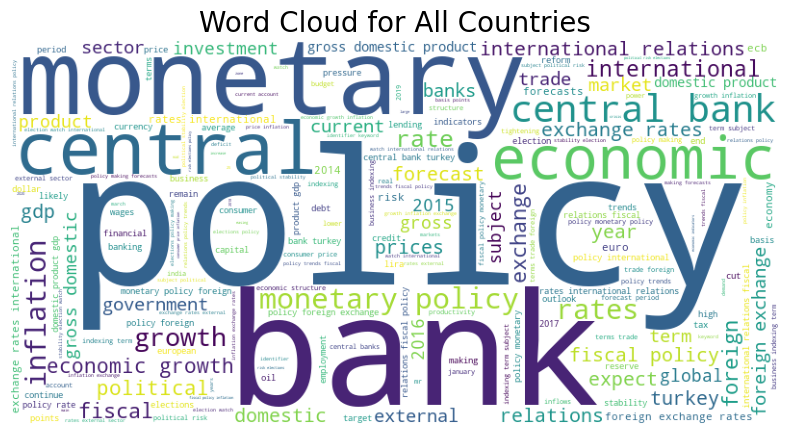

In [ ]:
# Create word cloud for all countries

reports_extractor.generate_wordcloud()

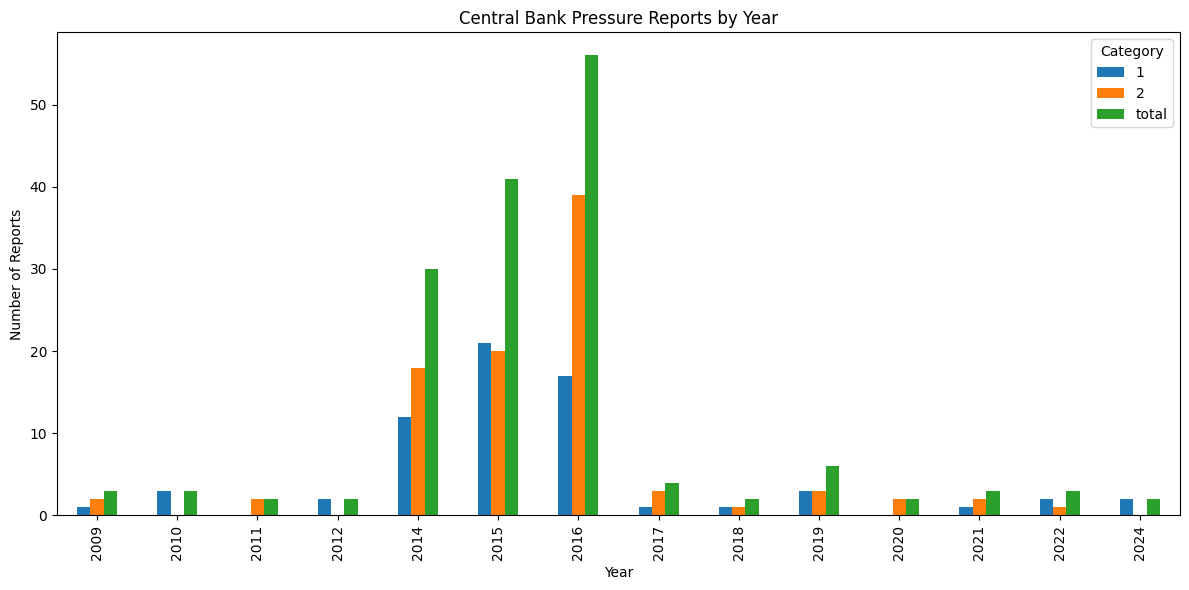

In [ ]:
reports_extractor.plot_pressure_histogram_by_year()

# Note on legend:
# Category 1 = Central bank is resisting pressure
# Category 2 = Cental bank is succumbing to pressure 

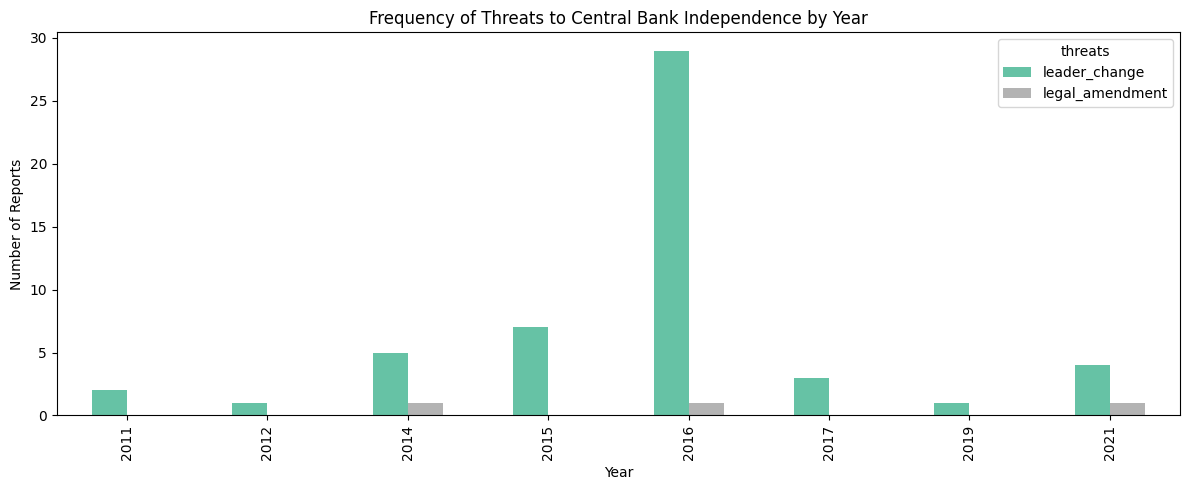

In [ ]:
# Threats can either:
# - leader_change: Threats to replace the central bank governor
# - legal_amendment: Threats to amend central bank law to decrease independence
reports_extractor.plot_threats_by_year()

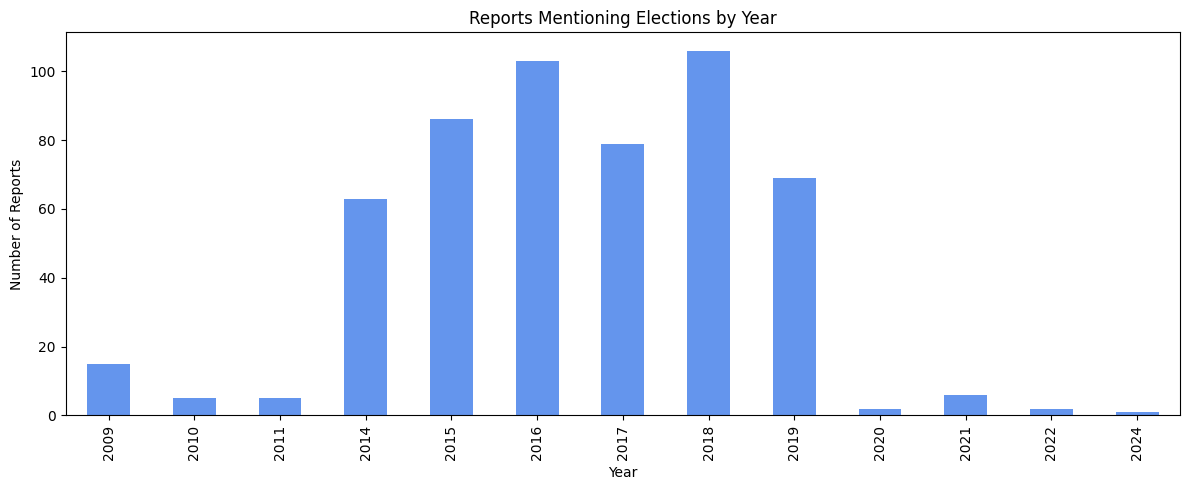

In [ ]:
# Is there mention of elections in the reports?

reports_extractor.plot_elections_by_year()

In [ ]:
# Ranking countries with the most pressure on central banks to change monetary policy

df_pressure = df[df['pressure'].isin([1, 2])]
pressure_counts_by_country = df_pressure.groupby('country')['pressure'].value_counts().unstack(fill_value=0)
pressure_counts_by_country['total_pressure'] = pressure_counts_by_country.sum(axis=1)
top_pressure = pressure_counts_by_country.sort_values(by='total_pressure', ascending=False)
top_pressure.head(10)

pressure,1,2,total_pressure
country,,,
Turkey,23,24,47
Russia,6,15,21
France,11,8,19
India,3,12,15
South Africa,4,2,6
Spain,0,5,5
Greece,2,3,5
United Kingdom,2,2,4
Egypt,1,3,4


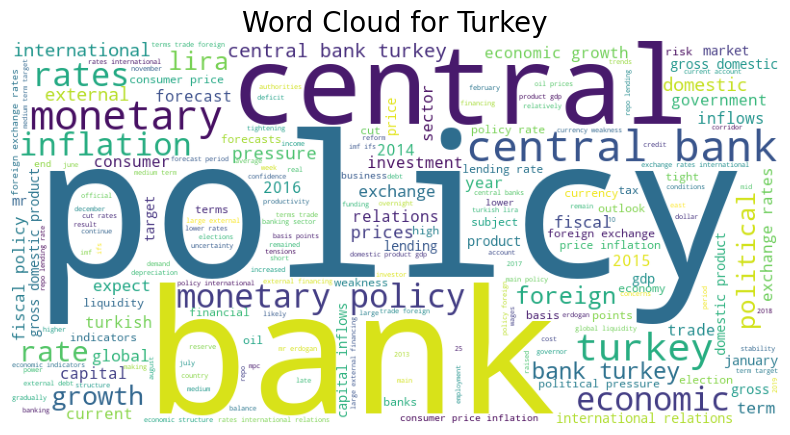

In [ ]:
# Word Cloud for Turkey (the country with most instances of pressure on its central bank)

reports_extractor.generate_wordcloud("Turkey")

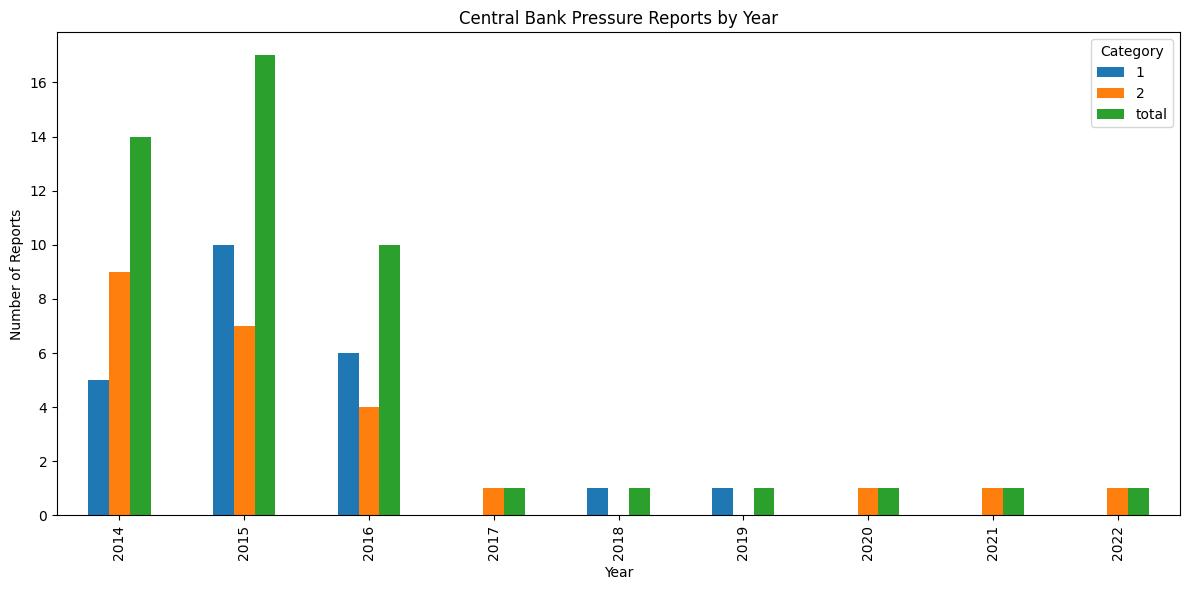

In [ ]:
# Categories of pressure on Turkey's central bank. To recall:
# Category 1 = Central bank is resisting pressure
# Category 2 = Cental bank is succumbing to pressure 

reports_extractor.plot_pressure_histogram_by_year("Turkey")

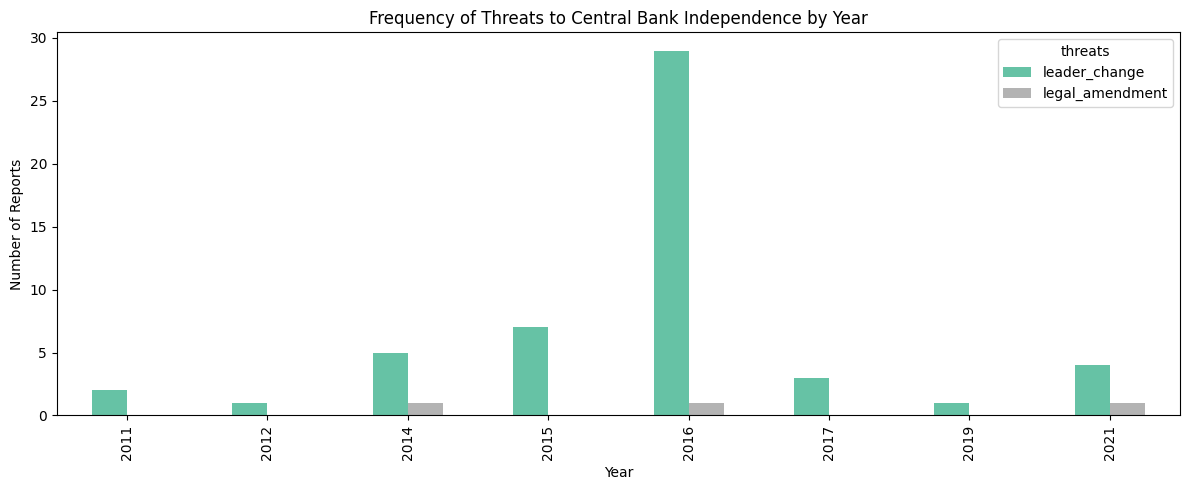

In [ ]:
# Kinds of threats to Turkey's central bank. To recall:
# - leader_change: Threats to replace the central bank governor
# - legal_amendment: Threats to amend central bank law to decrease independence

reports_extractor.plot_threats_by_year("Turkey")

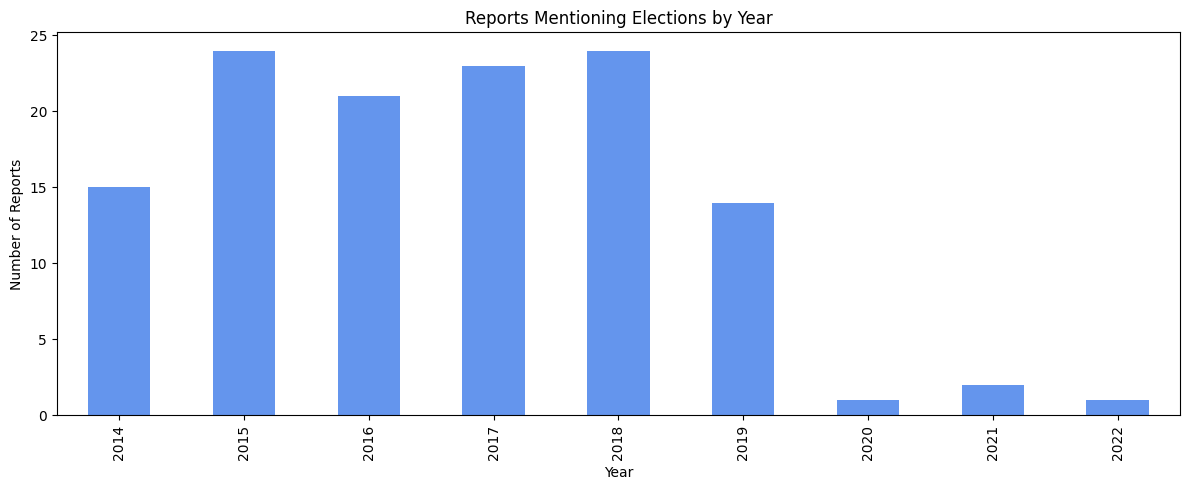

In [ ]:
# Mentions of elections in country report for Turkey

reports_extractor.plot_elections_by_year("Turkey")

In [ ]:
# Fetch de jure CBI Index and long-term interest rate (ltrate) for Turkey
# This is similar to Milestones 1 and 2 in the group project

import pandas as pd
sys.path.append("../../../")
from src.data.download_cbidata import CbiDataPipeline
from src.data.download_macrodata import MacroDataPipeline


cbi_pipe = CbiDataPipeline()
cbi_pipe.get_cbi_data()

indicators=["ltrate"]
macro = MacroDataPipeline(indicators)
df_ltrate_raw = macro.get_macro_data()

df_cbi_final = cbi_pipe.rename_clean()
df_ltrate_final = macro.rename_clean()

print(df_cbi_final.columns)


df_cbi_final['country'] = df_cbi_final['country name']
df_ltrate_final['country'] = df_ltrate_final['countryname']


df_main = pd.merge(
    df_cbi_final[['country', 'year', 'cbie_index']],
    df_ltrate_final[['country', 'year', 'ltrate']],
    on=['country', 'year'],
    how='inner'
)

df_turkey = df_main[df_main["country"] == "Turkey"]




CBI data file already exists
Macro data file already exists
CBI clean data file already exists
Macro data file already exists
Index(['Unnamed: 0', 'country name', 'year', 'country', 'imf_country_code',
       'cbie_index', 'cbie_index_ref', 'cbie_board', 'cbie_board_ref',
       'cbie_board_q1', 'cbie_board_q2', 'cbie_board_q3', 'cbie_board_q4',
       'cbie_board_q5', 'cbie_board_q6', 'cbie_board_q7', 'cbie_board_q8',
       'cbie_board_q9', 'cbie_board_q10', 'cbie_board_q11', 'cbie_board_q12',
       'cbie_board_q13', 'cbie_board_q14', 'cbie_policy', 'cbie_policy_ref',
       'cbie_policy_q1', 'cbie_policy_q2', 'cbie_policy_q3', 'cbie_policy_q4',
       'cbie_policy_q5', 'cbie_obj', 'cbie_obj_ref', 'cbie_lending',
       'cbie_lending_ref', 'cbie_lending_q1', 'cbie_lending_q2',
       'cbie_lending_q3', 'cbie_lending_q4', 'cbie_lending_q5',
       'cbie_lending_q6', 'cbie_lending_q7', 'cbie_lending_q8',
       'cbie_finindep', 'cbie_finindep_ref', 'cbie_finindep_q1',
       'cbie_fin

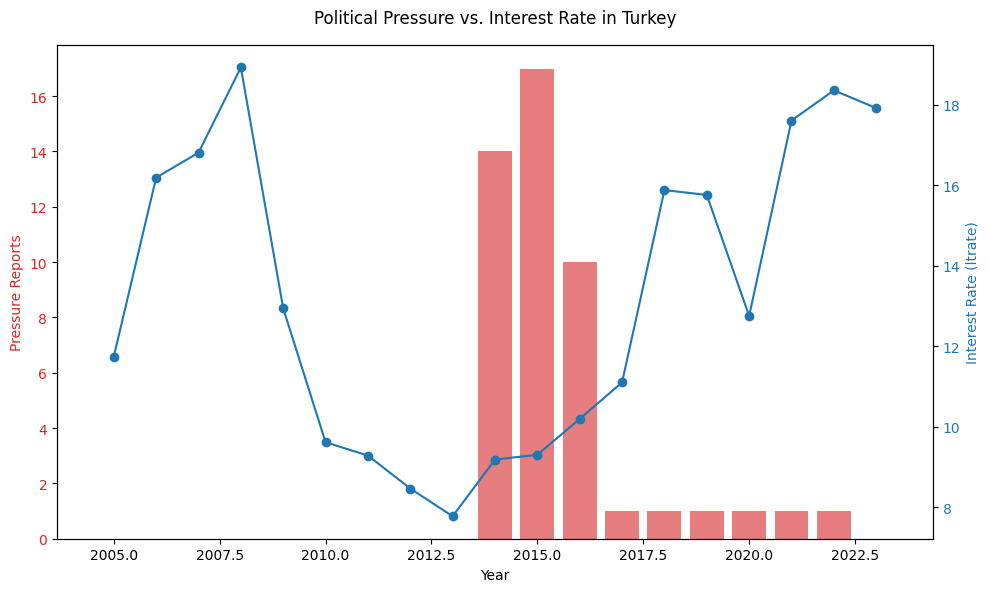

In [ ]:
# Plot ltrate and instance of pressure on Turkey's central bank

import matplotlib.pyplot as plt

# Filter pressure data and extract year
df_pressure = df[df['pressure'].isin([1, 2])].copy()
df_pressure['year'] = pd.to_datetime(df_pressure['date'], errors='coerce').dt.year
df_pressure_turkey = df_pressure[df_pressure['country'] == "Turkey"]

# Count pressure reports by year
pressure_by_year = df_pressure_turkey.groupby('year')['pressure'].count().reset_index()
pressure_by_year.rename(columns={'pressure': 'pressure_count'}, inplace=True)

# Merge with macroeconomic data
df_plot = pd.merge(df_turkey, pressure_by_year, on='year', how='left').fillna(0)

# Plot
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel('Year')
ax1.set_ylabel('Pressure Reports', color='tab:red')
ax1.bar(df_plot['year'], df_plot['pressure_count'], color='tab:red', alpha=0.6, label='Pressure')
ax1.tick_params(axis='y', labelcolor='tab:red')

ax2 = ax1.twinx()
ax2.set_ylabel('Interest Rate (ltrate)', color='tab:blue')
ax2.plot(df_plot['year'], df_plot['ltrate'], color='tab:blue', marker='o', label='Interest Rate')
ax2.tick_params(axis='y', labelcolor='tab:blue')

fig.suptitle('Political Pressure vs. Interest Rate in Turkey')
fig.tight_layout()
plt.show()

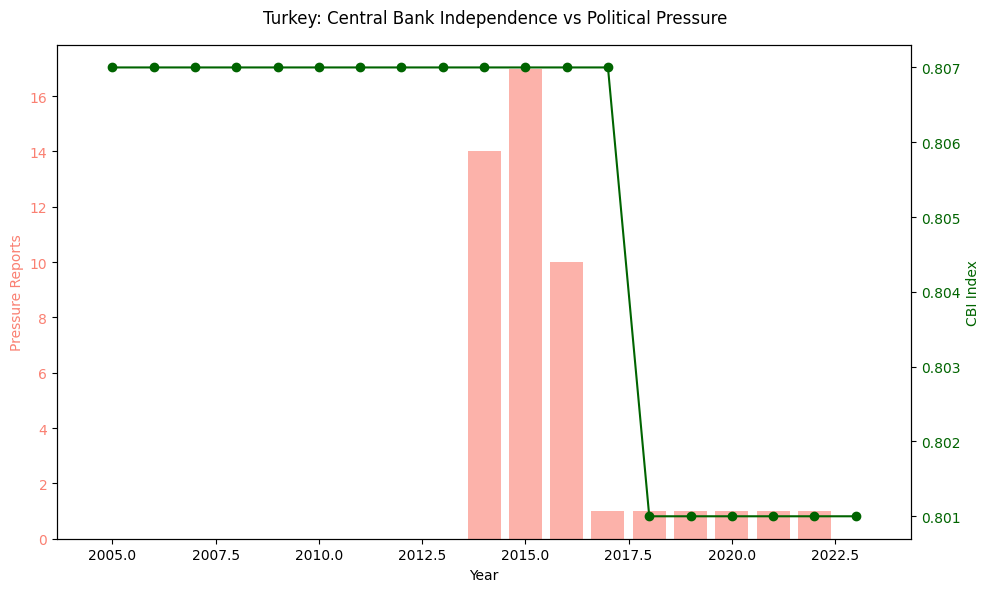

In [ ]:
# Compare de jure and de facto central bank indices for Turkey

fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot: pressure count per year
ax1.bar(df_plot['year'], df_plot['pressure_count'], color='salmon', alpha=0.6, label='Pressure Reports')
ax1.set_xlabel('Year')
ax1.set_ylabel('Pressure Reports', color='salmon')
ax1.tick_params(axis='y', labelcolor='salmon')

# Line plot: CBI index over time
ax2 = ax1.twinx()
ax2.plot(df_plot['year'], df_plot['cbie_index'], color='darkgreen', marker='o', label='CBI Index')
ax2.set_ylabel('CBI Index', color='darkgreen')
ax2.tick_params(axis='y', labelcolor='darkgreen')

fig.suptitle('Turkey: Central Bank Independence vs Political Pressure')
fig.tight_layout()
plt.show()


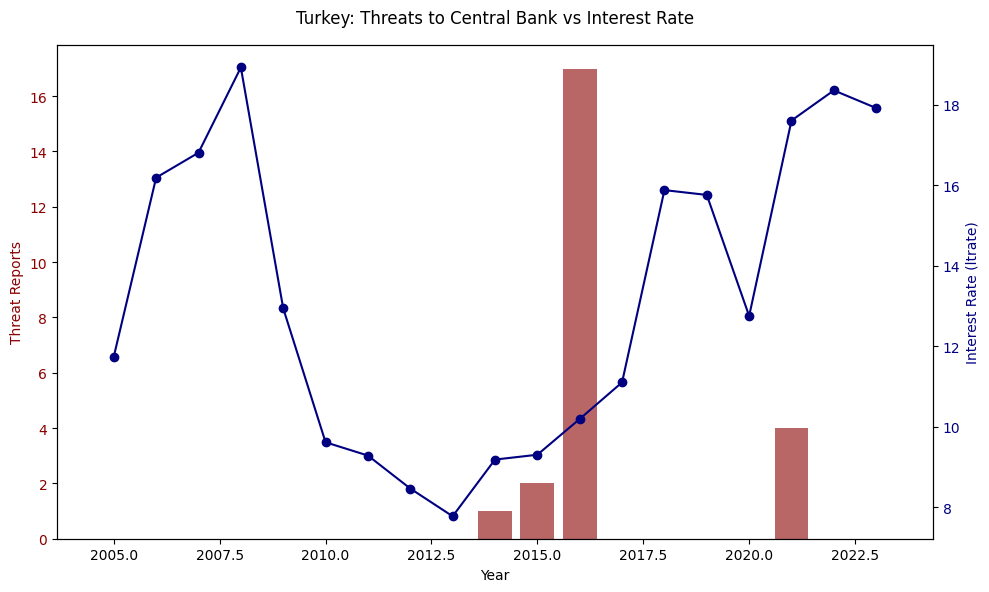

In [42]:
# Explode threat list so we can count per year
df_threats = df.copy()
df_threats = df_threats[df_threats['country'] == 'Turkey'].explode('threats')
df_threats['year'] = pd.to_datetime(df_threats['date'], errors='coerce').dt.year

# Count threats per year
threats_by_year = df_threats.dropna(subset=['threats']).groupby('year')['threats'].count().reset_index()
threats_by_year.rename(columns={'threats': 'threat_count'}, inplace=True)

# Merge with macroeconomic + CBI data
df_threat_plot = pd.merge(df_turkey, threats_by_year, on='year', how='left').fillna(0)

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar chart for threats
ax1.bar(df_threat_plot['year'], df_threat_plot['threat_count'], color='darkred', alpha=0.6)
ax1.set_xlabel('Year')
ax1.set_ylabel('Threat Reports', color='darkred')
ax1.tick_params(axis='y', labelcolor='darkred')

# Line plot for ltrate
ax2 = ax1.twinx()
ax2.plot(df_threat_plot['year'], df_threat_plot['ltrate'], color='navy', marker='o')
ax2.set_ylabel('Interest Rate (ltrate)', color='navy')
ax2.tick_params(axis='y', labelcolor='navy')

fig.suptitle('Turkey: Threats to Central Bank vs Interest Rate')
fig.tight_layout()
plt.show()
